<a href="https://colab.research.google.com/github/Ouasfi/EEG-ssl/blob/master/Self_supervised_EEG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Uncovering the structure of clinical EEG signals with self-supervised learning

This notebook aims to reproduce the experiments presented  [here](https://arxiv.org/abs/2007.16104 ). 
- As feature extractors we used :
    - StagerNet
    - ShalloNet 
    - A transformer like model ( instead of GRU)
- As classifiers :
    - Logistic regression 
    - SVM 
    - Multilayer perceptron 

Datasets used in this experiment include: 
  - TUH Abnormal dataset 
  - Physionet Challenge 2018 (PC18)

In [ ]:
import torch
from torch.nn import *
from pylab import *
import torch
from torch import optim
from torch.utils import data
from torch import nn
from torch.nn.functional import soft_margin_loss #!

# Preprocessing

# Pytorch dataloader

## Relative positioning

- A the multivariate time series S, 
- Sample pairs of time windows $(x_t,x_t′)$
  -  window $x_t$, $x_t′$ is in $R^{C×T} $ 
  - T is the duration of each window,
  - index t indicates the time sample at which the window starts in S. 

**Our assumption is that an appropriate representation of the data should evolve slowly over time**


$ Z_N =[((x_{t_i},x_{t′_i}),y_i) |i∈􏰀N􏰁,(t_i,t′_i)∈T,yi ∈Y]$

- $ y_i = −1, if \quad |t_i − t′_i| > τ_{neg}$
- $ y_i = 1, if \quad |t_i − t′_i| < τ_{pos}$

In [ ]:
T = 30
C = 12
M = int(1e5)
S = torch.tensor(rand( C, M))

In [ ]:
class WeightedSampler(torch.utils.data.sampler.Sampler):
    r"""Sample des windows randomly
    Arguments:
    ---------
        dataset (Dataset): dataset to sample from
        size (int): The total number of sequences to sample
    """

    def __init__(self,dataset, batch_size,size,  weights):
        
        
        self.batch_size = batch_size
        self.size = size
        self.dataset = dataset
        self.serie_len = len(self.dataset)
        
        self.weights = torch.DoubleTensor(weights)
        
    def __iter__(self):
        num_batches = self.size// self.batch_size
        while num_batches > 0:
            print()
            sampled = 0
            while sampled < self.batch_size:
                target  = 2*torch.multinomial(
            self.weights, 1, replacement=True) -1
                t = choice(arange(0, self.serie_len-dataset.temp_len, 1))
                t_ = dataset.get_pos(t) if target>0 else dataset.get_neg(t)
                sampled += 1
                yield (t, t_, target)
            
            num_batches -=1

    def __len__(self):
        return len(self.train_list)   

In [ ]:
class Abstract_Dataset(torch.utils.data.Dataset):
    '''
    Classe dataset  pour les differents sampling
    '''
    def __init__(self, time_series, temp_len = T, n_features = C):

        self.time_series = time_series
        self.temp_len = temp_len
        self.n_features = n_features
    def get_windows(self,index):
        '''
        a method to load  a sequence 
        '''
        raise NotImplementedError
    def get_pos(self, t_anchor):
        '''
        a method to get positive samples
        '''
        raise NotImplementedError
    def get_neg(self, t_anchor):
        '''
       a method to get negative samples
        '''
        raise NotImplementedError
    def get_targets(self, index):
        '''
        a method to get labels
        '''
        raise NotImplementedError
    def __getitem__(self, index):
        windows = self.get_windows(index)
        target = self.get_targets(index)
        return windows, target
    def __len__(self): return self.time_series.shape[1]

class RP_Dataset(Abstract_Dataset):
    
    def __init__(self, time_series, sampling_params, temp_len = T, n_features = C):
      super().__init__(time_series, temp_len = temp_len, n_features = n_features)
      self.pos , self.neg = sampling_params
    def get_windows(self,index):
        '''
        a method to get sampled windows
        '''
        (t, t_ , _) = index
        anchor_wind = self.time_series[:,t:t+self.temp_len]
        neg_wind = self.time_series[:,t_:t_+self.temp_len] # could be negative or positive
        return (anchor_wind, neg_wind)
    
    def get_targets(self, index):
        return index[-1]
    def get_pos(self, t_anchor):

      start = min(0,t_anchor-self.pos ) 
      end = min(self.__len__()-self.temp_len,t_anchor+self.pos ) # to get a sequence of lenght self.temp_lenght
      t_ = choice(arange(start,end, 1)) 
      return t_
    def get_neg(self, t_anchor):
      
      left_idx = arange(0, min(0, t_anchor - self.neg), 1)
      right_idx =arange(min(self.__len__()-self.temp_len, t_anchor + self.neg),self.__len__()-self.temp_len ,1)
      t_ = choice(hstack([left_idx, right_idx]))
      return t_

def collate(batch):
    anchors = torch.stack([item[0][0] for item in batch])
    sampled = torch.stack([item[0][1] for item in batch])
    targets = torch.stack([item[1] for item in batch])
    
    return (anchors, sampled), targets

In [ ]:

dataset = RP_Dataset(S, (5, 10), temp_len = T, n_features = C)
sampler = WeightedSampler(dataset, batch_size = 5 ,size = 10,  weights = [0.5, 0.5])
loader = torch.utils.data.DataLoader(dataset, batch_size=5,  sampler=sampler,
           batch_sampler=None, num_workers=0, collate_fn=collate)

for (anchors, sampled), targets in loader: 
  print(sampled.shape)
  print(targets)


torch.Size([5, 12, 30])
tensor([[-1],
        [ 1],
        [ 1],
        [ 1],
        [-1]])

torch.Size([5, 12, 30])
tensor([[ 1],
        [ 1],
        [ 1],
        [ 1],
        [-1]])


## Temporal shuffling

-  Two anchor windows $x_t$ and $x_{t^{′′}}$ from the positive context,  
- A third window $x_t'$ that is either between the first two windows or in the negative context.
- Construct window triplets that are either temporally ordered (t < t′ < t′′) or shuffled (t < t′′ < t′ or t′ < t < t′′). 
- We augment the number of possible triplets by also considering the mirror image of the previous triplets, e.g., ($x_t$, $x_t'$ , $x_{t^{′′}}$ ) becomes ($x_{t^{′′}}$ , $x_t'$ , $x_t$).
-  The label $y_i$ then indicates whether the three windows are ordered or have been shuffled, similar to [23].


# Models

## Encoders

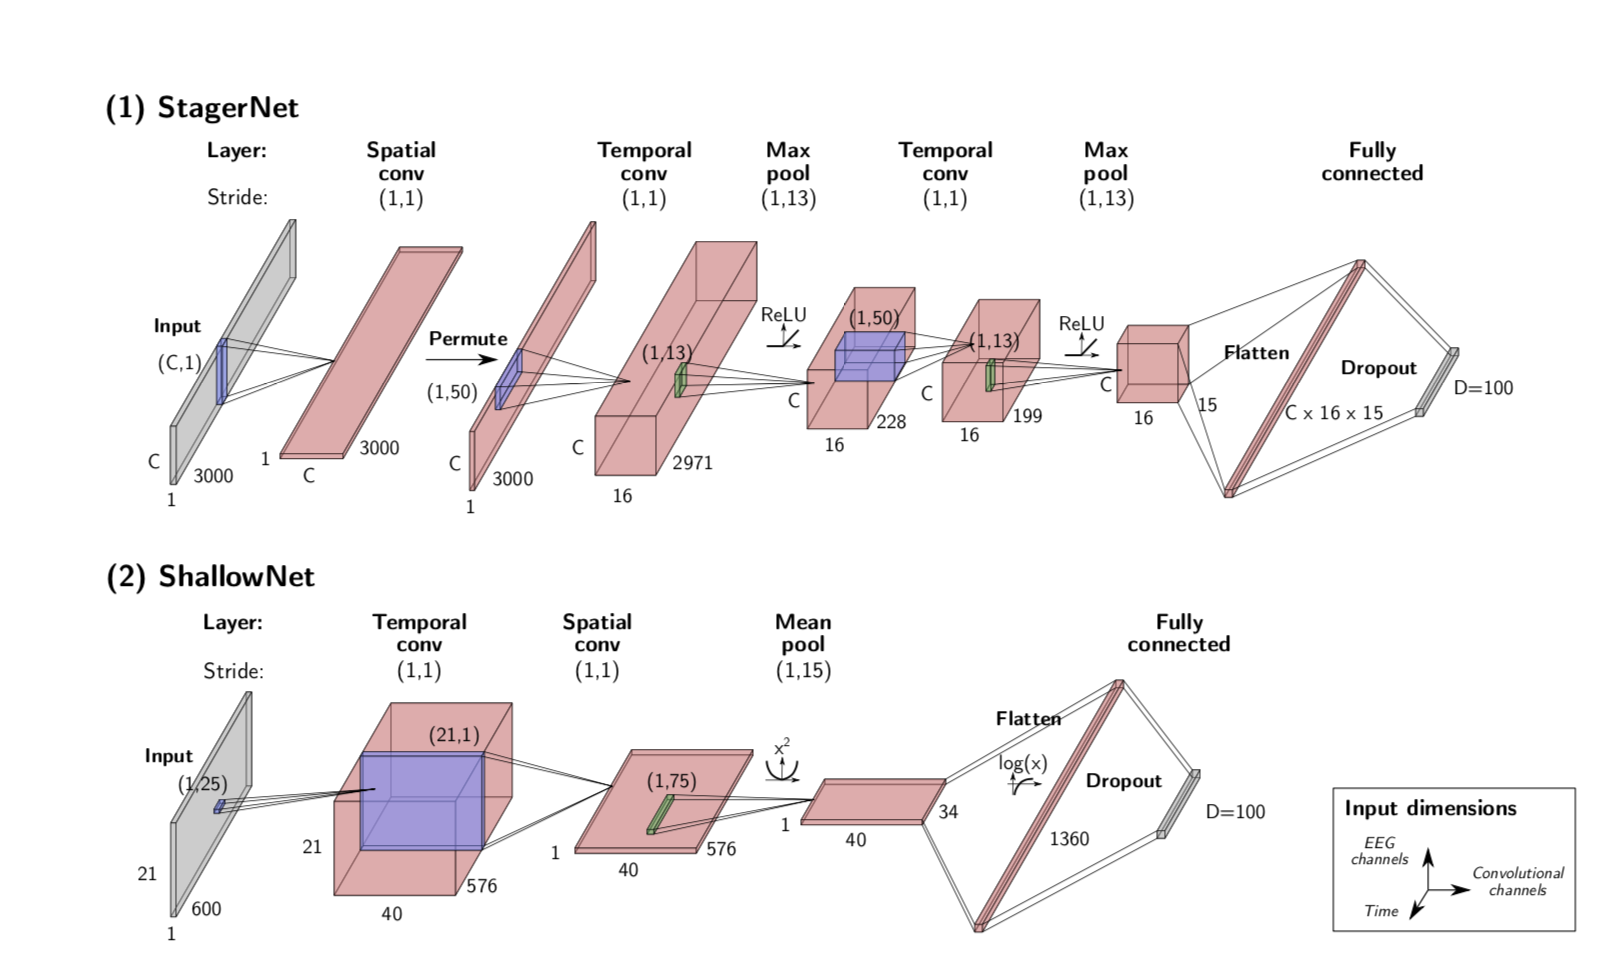

In [ ]:
from IPython.display import Image
Image(filename='models.png')

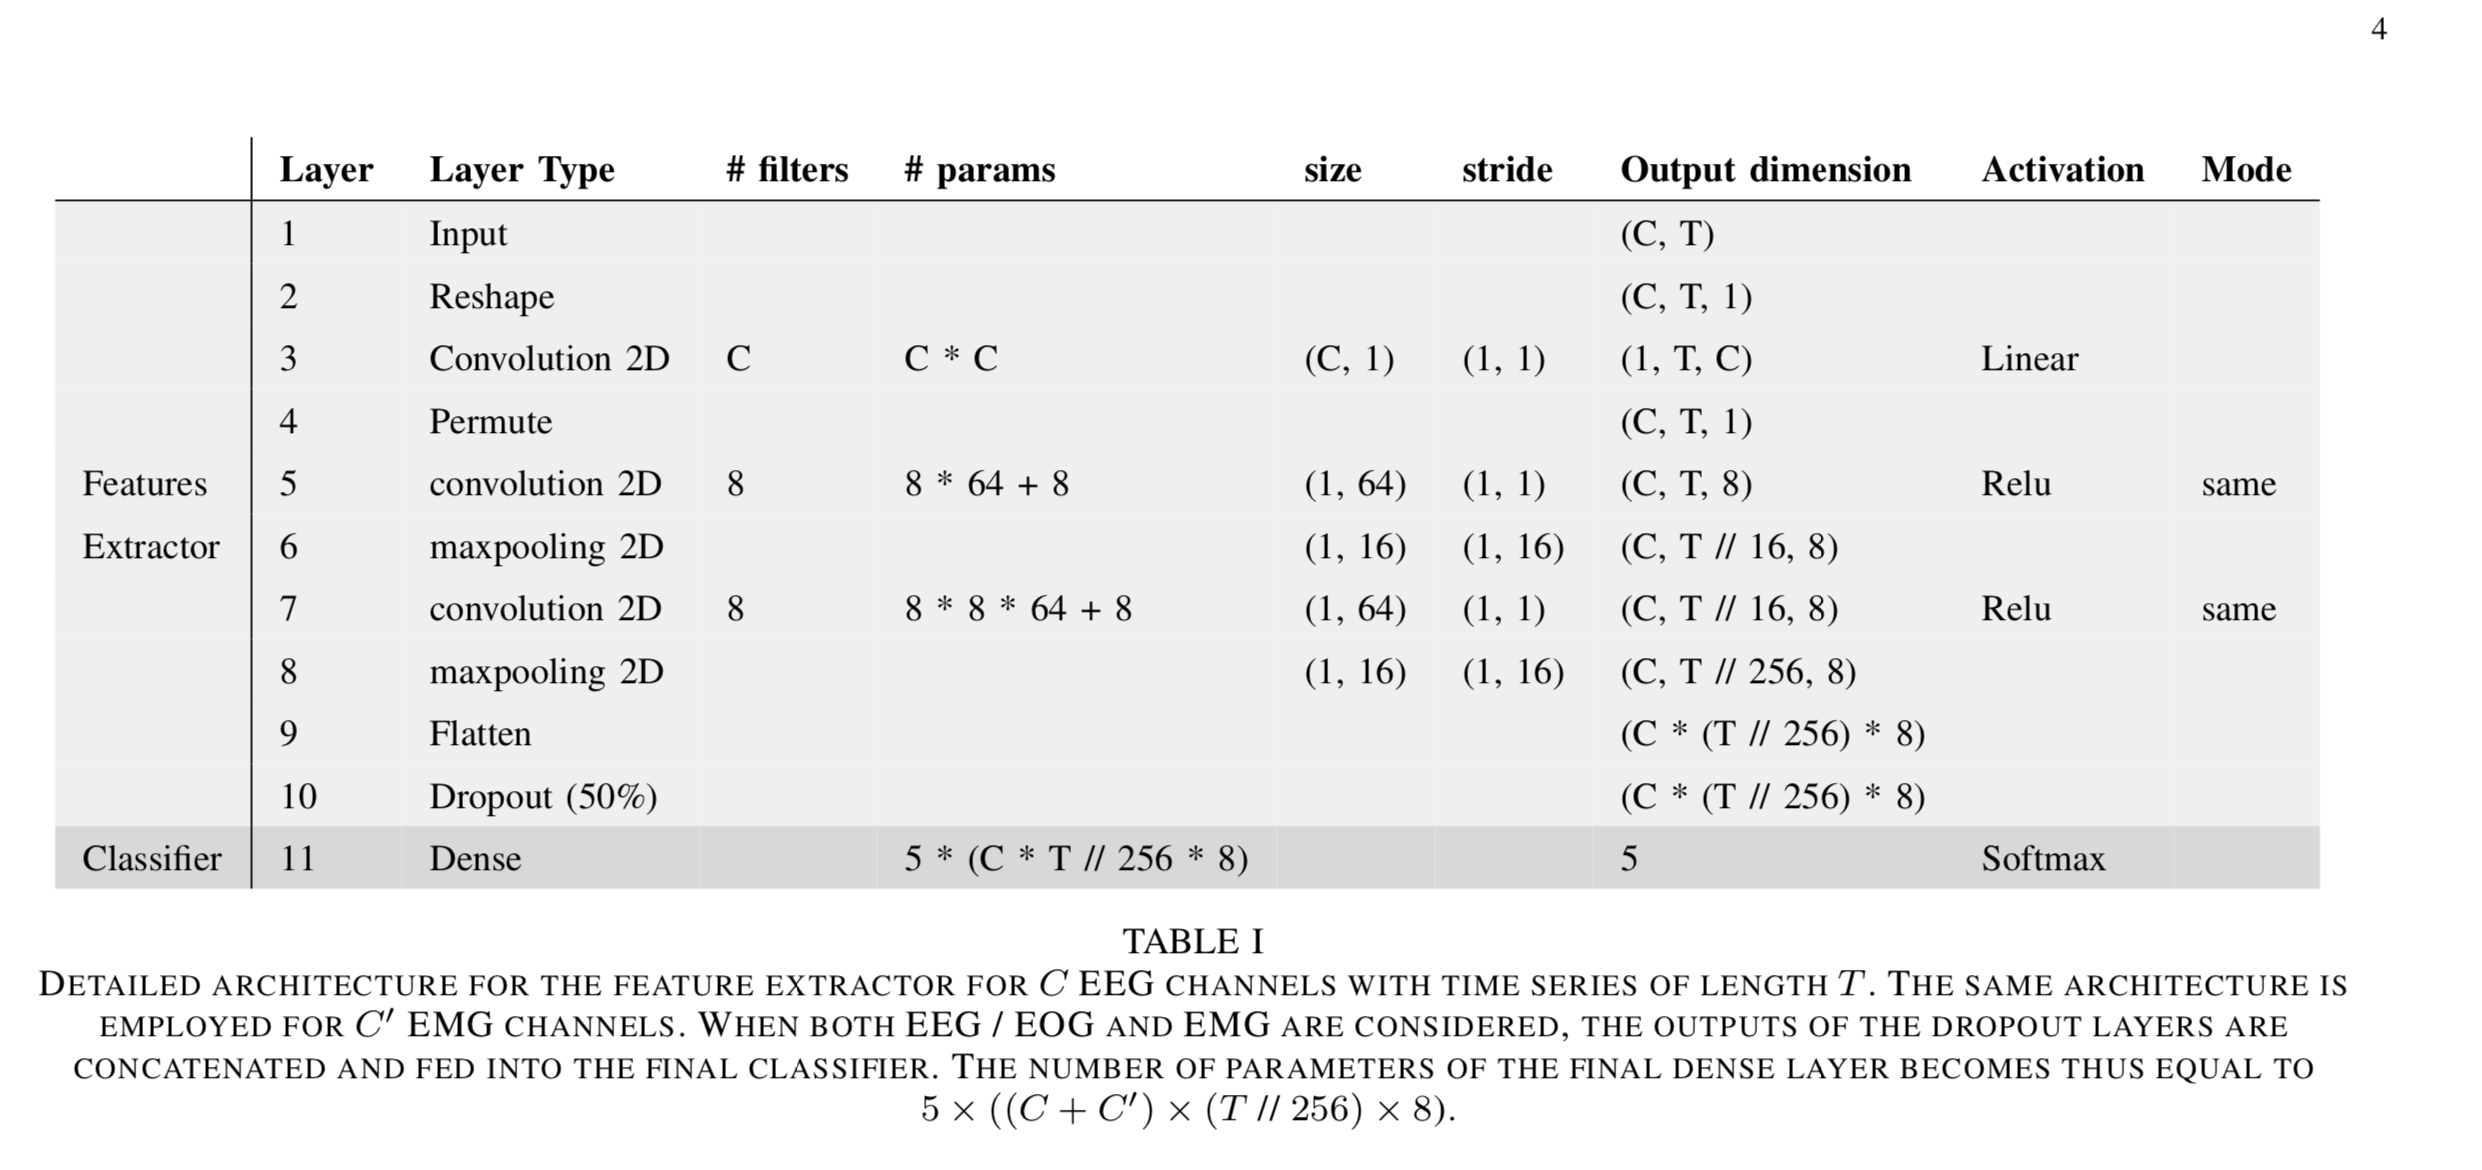

In [ ]:
#@title StagerNet (the original architecture)
Image(filename='stagerNEt.png') 

In [ ]:
C = 12
T = 3000
class StagerNet(Module):
    """
     StagerNet implementation.    
    """
    def __init__(self, num_classes, num_channels = C, temp_lenght = T):
        super().__init__()      
        # create conversion layer
        self.relu = ReLU()
        self.spatial_conv = Conv2d(1, num_channels, (num_channels,1), stride= (1,1))
        self.temp_conv1 =  Conv2d(1, 16, (1,51), stride= (1,1), padding= (0,(51-1)//2))#(51-1)//2 to insure same padding
        self.batch_norm1 = BatchNorm2d(16)
        self.temp_conv2 =  Conv2d(16, 16, (1,51), stride= (1,1), padding= (0,(51-1)//2))#(51-1)//2 to insure same padding
        self.batch_norm2 = BatchNorm2d(16)
        self.maxPool = MaxPool2d((1, 13), stride=(1, 13))
        self.flatten = Flatten()
        self.dropout = Dropout(p = 0.5)
        self.linear_class = Linear(num_channels*(temp_lenght//(13*13))*16,num_classes )        
    def forward(self, inputs):
      x = self.spatial_conv(inputs)
      x = x.permute(0,2,1,3)
      x = self.relu(self.temp_conv1(x))
      # a relu activation is used before batch_norm, is it the case in the original implementation ?
      x = self.batch_norm1(x) 
      x = self.relu(x)      
      x = self.maxPool(x)
      x = self.relu(self.temp_conv2(x)) 
      x = self.batch_norm2 (x)
      x = self.relu(x)
      x = self.maxPool(x)
      x = self.dropout(self.flatten(x))
      x = self.linear_class(x)
      return x
        

        

In [ ]:
T = 600
C = 21
class ShallowNet(Module):
    """
     ShallowNet implementation.    
    """
    def __init__(self, num_classes, num_channels = C, temp_lenght = T):
        super().__init__()      
        # create conversion layer
        self.eps = 1e-45
        self.relu = ReLU()
        
        self.temp_conv1 =  Conv2d(1, 40, (1,25), stride= (1,1))
        self.batch_norm2 = BatchNorm2d(40)
        self.spatial_conv = Conv2d(40, 40, (num_channels,1), stride= (1,1))
        self.meanPool = AvgPool2d((1, 75), stride=(1, 15))
        self.flatten = Flatten()
        self.dropout = Dropout(p = 0.5)
        self.num_features = (((temp_lenght-25+1)-75)//15+1)*40
        self.linear_class = Linear( self.num_features,num_classes )  

    def forward(self, inputs):
      x = self.temp_conv1(inputs)
      x = self.batch_norm2(x)
      x = self.spatial_conv(x)
      x = torch.pow(x, 2) # squaring non-linearity

      x = self.meanPool(x)
      x = self.flatten(x)
      x = torch.log(x+self.eps) #log  non-linearity 
      
      x = self.dropout(self.flatten(x))
      x = self.linear_class(x)
      return x

In [ ]:

from pylab import *
model = ShallowNet(10)
inputs = torch.tensor(rand(1,1, 21, 600))
model.to(float)
y = model(inputs)
y.shape

torch.Size([1, 40, 21, 576])
torch.Size([1, 40, 1, 576])
torch.Size([1, 40, 1, 34])
torch.Size([1, 1360])


torch.Size([1, 10])

## classifiers

In [ ]:
class SSL_Linear(nn.Module):
	def __init__(self, model, loss_weights):
		super().__init__()
		self.model = model
		self.model.requires_grad = False
		self.linear = nn.Linear(100, 5)
		self.loss_fn = nn.CrossEntropyLoss(weight=loss_weights)

	def forward(self, x):
		with torch.no_grad():
			features = self.model.feature_extractor(x)
		out = self.linear(features)
		return out

	def loss(self, x, y_true):
		out = self(x)
		return self.loss_fn(out, y_true)

In [ ]:
class Relative_Positioning(nn.Module):
  def __init__(self, EEG_FeatureExtractor, C, T, k=50, m=13, dropout_prob=0.5, embedding_dim=100, n_spatial_filters=8):
    super().__init__()
    self.feature_extractor = EEG_FeatureExtractor(C, T, k, m, dropout_prob, embedding_dim, n_spatial_filters).cuda()
    self.linear = nn.Linear(embedding_dim, 1)
    self.loss_fn = nn.SoftMarginLoss()

  def forward(self, x):
    first_samples = x[:,0].unsqueeze(dim=1)
    second_samples = x[:,1].unsqueeze(dim=1)

    h_first = self.feature_extractor(first_samples)
    h_second = self.feature_extractor(second_samples)

    h_combined = torch.abs(h_first - h_second)

    out = self.linear(h_combined)
    return out

In [ ]:
class Temporal_Shuffling(nn.Module):
  def __init__(self,EEG_FeatureExtractor, C, T, k=50, m=13, dropout_prob=0.5, embedding_dim=100, n_spatial_filters=8):
    super().__init__()
    self.feature_extractor = EEG_FeatureExtractor(C, T, k, m, dropout_prob, embedding_dim, n_spatial_filters).cuda()
    self.linear = nn.Linear(2*embedding_dim, 1)
    self.loss_fn = nn.BCEWithLogitsLoss()

  def forward(self, x):
    first_samples = x[:,0].unsqueeze(dim=1)
    second_samples = x[:,1].unsqueeze(dim=1)
    third_samples = x[:,2].unsqueeze(dim=1)

    h_1 = self.feature_extractor(first_samples) # (bs, z_dim)
    h_2 = self.feature_extractor(second_samples)
    h_3 = self.feature_extractor(third_samples)

    h_1_2 = torch.abs(h_1 - h_2)
    h_2_3 = torch.abs(h_2 - h_3)

    h_combined = torch.cat((h_1_2, h_2_3), dim=1)

    out = self.linear(h_combined)
    return out
  
  def loss(self, x, labels):
    out = self(x)
    return self.loss_fn(out, labels)

## Training loop

In [ ]:
def normalize(x):
	x_normalized = (x - x.mean(2).reshape(x.shape[0],x.shape[1],1))/(x.std(2).reshape(x.shape[0],x.shape[1],1))
	return x_normalized

def normalize_one(x):
	x_normalized = (x - x.mean(1).reshape(x.shape[0],1))/(x.std(1).reshape(x.shape[0],1))
	return x_normalized

def get_loss_weights(epochs_train):
	y_train = epochs_train.events[:, 2] - 1 # start at 0
	counts = np.bincount(y_train)
	weights = len(y_train) / (counts * len(counts))
	print("Class weights", weights)
	return torch.from_numpy(weights).cuda().float()

def load_losses(saved_models_dir, name):
	with open(op.join(saved_models_dir, name + '_train_losses.npy'), 'rb') as f:
		train_losses = list(np.load(f))
	with open(op.join(saved_models_dir, name + '_test_losses.npy'), 'rb') as f:
		test_losses = list(np.load(f))
	return train_losses, test_losses

def save_losses(train_losses, test_losses, saved_models_dir, name):
	with open(op.join(saved_models_dir, name + '_train_losses.npy'), 'wb') as f:
		np.save(f, train_losses)
	with open(op.join(saved_models_dir, name + '_test_losses.npy'), 'wb') as f:
		np.save(f, test_losses)

In [ ]:
def rp_loss(model, x, y):
	out = model(x)
	return soft_margin_loss(out, y)
 
def _train(model, train_loader, optimizer, epoch):
	model.train()
	
	train_losses = []
	for pair in train_loader:
		x, y = pair[0], pair[1]
		x = x.cuda().float().contiguous()
		y = y.cuda().float().contiguous()
		loss = rp_loss(model, x, y)
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()
		train_losses.append(loss.item())
	return train_losses

def _eval_loss(model, data_loader):
	model.eval()
	total_loss = 0
	with torch.no_grad():
		for pair in data_loader:
			x, y = pair[0], pair[1]
			x = x.cuda().float().contiguous()
			y = y.cuda().float().contiguous()
			loss = rp_loss(model, x, y)
			total_loss += loss * x.shape[0]
		avg_loss = total_loss / len(data_loader.dataset)

	return avg_loss.item()

In [ ]:
def _train_epochs(model, train_loader, test_loader, train_args):
	epochs, lr = train_args['epochs'], train_args['lr']
	optimizer = optim.Adam(model.parameters(), lr=lr)
	if not os.path.exists(saved_models_dir):
		os.makedirs(saved_models_dir)
	
	train_losses = []
	test_losses = [_eval_loss(model, test_loader)]
	for epoch in range(1, epochs+1):
		model.train()
		train_losses.extend(_train(model, train_loader, optimizer, epoch))
		test_loss = _eval_loss(model, test_loader)
		test_losses.append(test_loss)
		print(f'Epoch {epoch}, Test loss {test_loss:.4f}')
		
		# save model every 10 epochs
		if epoch % 10 == 0:
			torch.save(model.state_dict(), op.join(root, 'saved_models', 'ssl_model_epoch{}.pt'.format(epoch)))
	torch.save(model.state_dict(), op.join(root, 'saved_models', 'ssl_model.pt'))
	return train_losses, test_losses




In [ ]:



model = Relative_Positioning(C, T, k=50, m=13, dropout_prob=0.5, embedding_dim=100, n_spatial_filters=8)
def train_ssl(model, train_dataset, test_dataset, n_epochs=20, lr=1e-3, batch_size=256, load_last_saved_model=False, num_workers=8):
	C = train_dataset.__getitem__(0)[0].shape[1] # num channels
	T = train_dataset.__getitem__(0)[0].shape[2] # num timepoints
	
	if load_last_saved_model:
		model.load_state_dict(torch.load(op.join(root, 'saved_models', 'ssl_model.pt')))

	if torch.cuda.device_count() > 1:
		model = nn.DataParallel(model)
	model.cuda()

	train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
	test_loader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

	new_train_losses, new_test_losses = _train_epochs(model, train_loader, test_loader, 
																				 dict(epochs=n_epochs, lr=lr))

	if load_last_saved_model:
		train_losses, test_losses = load_losses(saved_models_dir, 'ssl')
	else:
		train_losses = []
		test_losses = []
	
	train_losses.extend(new_train_losses)
	test_losses.extend(new_test_losses)

	save_losses(train_losses, test_losses, saved_models_dir, 'ssl')

	return train_losses, test_losses, model





## Inference

## Scores

In [ ]:
from sklearn.metrics import balanced_accuracy_score, accuracy_score
import torch
from torch import nn
import numpy as np
from .train_helpers import normalize
from torch.utils import data

def get_test_results(model, test_loader):
	y_true = []
	y_pred = []
	model.eval()
	softmax = nn.Softmax()
	with torch.no_grad():
		for pair in test_loader:
			x, y = pair[0], pair[1]
			x = x.cuda().float().contiguous()
			y = y.cuda().long().contiguous()
			out = model(x)
			_, predicted = torch.max(softmax(out.data), 1)
			y_true.extend(list(y.cpu().numpy()))
			y_pred.extend(list(predicted.cpu().numpy()))
	return y_true, y_pred

def scores(model, epochs_test):
	X_test = normalize(epochs_test.get_data())
	y_test = epochs_test.events[:, 2] - 1
	test_dataset = data.TensorDataset(torch.tensor(X_test).unsqueeze(1), torch.tensor(y_test))
	test_loader = data.DataLoader(test_dataset, batch_size=128, shuffle=False)
	
	y_true, y_pred = get_test_results(model, test_loader)
	acc_score = accuracy_score(y_true, y_pred)
	balanced_acc_score = balanced_accuracy_score(y_true, y_pred)
	print(f'Performance of the network on the {len(test_loader.dataset)} test images:')
	print(f'\tAccuracy: {100*acc_score:.2f}%')
	print(f'\tBalanced accuracy: {100*balanced_acc_score:.2f}%')
	return acc_score, balanced_acc_score